In [1]:
!unzip "/content/drive/MyDrive/2-1.zip" -d "/content/Task-1"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Task-1/2-1/images/v2-115522.png  
  inflating: /content/Task-1/2-1/images/v2-126632.png  
  inflating: /content/Task-1/2-1/images/v2-16464.png  
  inflating: /content/Task-1/2-1/images/v2-59059.png  
  inflating: /content/Task-1/2-1/images/v2-114278.png  
  inflating: /content/Task-1/2-1/images/v2-120141.png  
  inflating: /content/Task-1/2-1/images/v2-164967.png  
  inflating: /content/Task-1/2-1/images/v2-28907.png  
  inflating: /content/Task-1/2-1/images/v2-59113.png  
  inflating: /content/Task-1/2-1/images/v2-71295.png  
  inflating: /content/Task-1/2-1/images/v2-09134.png  
  inflating: /content/Task-1/2-1/images/v2-134327.png  
  inflating: /content/Task-1/2-1/images/v2-139868.png  
  inflating: /content/Task-1/2-1/images/v2-25641.png  
  inflating: /content/Task-1/2-1/images/v2-62085.png  
  inflating: /content/Task-1/2-1/images/v2-66198.png  
  inflating: /content/Task-1/2-1/images/v2-92663.png  
  infla

In [2]:
import torch
import numpy as np
import pandas as pd
import cv2
import time
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
def adding_label(df):
    unique_symbols = sorted(df["symbol_id"].unique())  # Sorted unique symbol_ids
    symbol_to_index = {symbol: i for i, symbol in enumerate(unique_symbols)}
    return symbol_to_index

def one_hot_encode(label, num_classes):
    one_hot = torch.zeros(num_classes)  # Create zero vector of shape (369,)
    one_hot[label] = 1  # Set the correct index to 1
    return one_hot

def load_and_flatten_image(img_path, target_size=(32, 32)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale (H, W)

    if img is None:
        print(f"Warning: Could not read {img_path}")
        return torch.zeros(target_size[0] * target_size[1], dtype=torch.float32)  # Empty tensor for missing files

    img = img.astype("float32") / 255.0  # Normalize to [0, 1]
    img = torch.tensor(img)  # Convert to PyTorch tensor

    return img.flatten()  # Convert to 1D tensor (1024,)


In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

class MLP:
    def __init__(self, input_size, output_size, hidden_sizes, learning_rate, activation_function, device=None):
        self.learning_rate = learning_rate
        self.activation = activation_function
        self.hidden_sizes = hidden_sizes
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def _Initialize(self, input_size, output_size):
        self.weights = []
        self.bias = []
        prev_size = input_size

        for hidden_size in self.hidden_sizes:
            self.weights.append(torch.randn(hidden_size, prev_size, dtype=torch.float32, device=self.device) * 0.01)
            self.bias.append(torch.randn(hidden_size, 1, dtype=torch.float32, device=self.device) * 0.01)
            prev_size = hidden_size

        self.weights.append(torch.randn(output_size, prev_size, dtype=torch.float32, device=self.device) * 0.01)
        self.bias.append(torch.randn(output_size, 1, dtype=torch.float32, device=self.device) * 0.01)

    def _Activation(self, x):
        if self.activation == 'relu':
            return torch.relu(x)
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)
        elif self.activation == 'tanh':
            return torch.tanh(x)
        elif self.activation == 'linear':
            return x

    def _ActivationPrime(self, x):
        if self.activation == 'relu':
            return torch.where(x > 0, torch.tensor(1.0, dtype=x.dtype, device=self.device), torch.tensor(0.0, dtype=x.dtype, device=self.device))
        elif self.activation == 'sigmoid':
            sig = torch.sigmoid(x)
            return sig * (1 - sig)
        elif self.activation == 'tanh':
            return 1 - torch.tanh(x) ** 2
        elif self.activation == 'linear':
            return torch.ones_like(x, device=self.device)

    def _Softmax(self, x):
        exp_x = torch.exp(x - torch.max(x, dim=1, keepdim=True).values)
        return exp_x / torch.sum(exp_x, dim=1, keepdim=True)

    def _CrossEntropy(self, y, y_hat):
        return -torch.mean(torch.sum(y * torch.log(y_hat + 1e-9), dim=1))

    def _Forward(self, X):
        X = X.to(self.device)
        activations = X
        self.layer_inputs = []
        self.z = []

        for i in range(len(self.weights) - 1):
            z = torch.mm(activations, self.weights[i].T) + self.bias[i].T
            activations = self._Activation(z)
            self.layer_inputs.append(activations)
            self.z.append(z)

        z = torch.mm(activations, self.weights[-1].T) + self.bias[-1].T
        self.layer_inputs.append(z)
        return self._Softmax(z)

    def _Backward(self, X, y, y_hat):
        batch_size = X.shape[0]
        dz = (y_hat - y) / batch_size
        grads_w, grads_b = [], []

        for i in range(len(self.weights) - 1, -1, -1):
            dw = torch.mm(dz.T, self.layer_inputs[i - 1] if i > 0 else X)
            db = torch.sum(dz, dim=0, keepdim=True).T

            if i > 0:
                dz = torch.mm(dz, self.weights[i]) * self._ActivationPrime(self.z[i - 1])

            grads_w.insert(0, dw)
            grads_b.insert(0, db)

        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads_w[i]
            self.bias[i] -= self.learning_rate * grads_b[i]

    def batch_fit(self, X, y, epochs):
        X, y = X.to(self.device), y.to(self.device)
        self._Initialize(X.shape[1], y.shape[1])
        losses, accuracies = [], []

        for epoch in range(epochs):
            y_hat = self._Forward(X)
            self._Backward(X, y, y_hat)

            loss = self._CrossEntropy(y, y_hat).item()
            acc = self.accuracy(y_hat, y)
            losses.append(loss)
            accuracies.append(acc)

        return losses, accuracies

    def Mini_batch_fit(self, X, y, epochs, batch_size):
        X, y = X.to(self.device), y.to(self.device)
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self._Initialize(X.shape[1], y.shape[1])
        losses, accuracies = [], []

        for epoch in range(epochs):
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                y_hat = self._Forward(X_batch)
                self._Backward(X_batch, y_batch, y_hat)

            y_pred = self._Forward(X)
            loss = self._CrossEntropy(y, y_pred).item()
            acc = self.accuracy(y_pred, y)
            losses.append(loss)
            accuracies.append(acc)

        return losses, accuracies

    def SGD_fit(self, X, y, epochs):
        X, y = X.to(self.device), y.to(self.device)
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
        self._Initialize(X.shape[1], y.shape[1])
        losses, accuracies = [], []

        for epoch in range(epochs):
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                y_hat = self._Forward(X_batch)
                self._Backward(X_batch, y_batch, y_hat)

            y_pred = self._Forward(X)
            loss = self._CrossEntropy(y, y_pred).item()
            acc = self.accuracy(y_pred, y)
            losses.append(loss)
            accuracies.append(acc)

        return losses, accuracies

    def predict(self, X):
        X = X.to(self.device)
        return self._Forward(X)

    def evaluate(self, X, y):
        X, y = X.to(self.device), y.to(self.device)
        y_hat = self._Forward(X)
        return self._CrossEntropy(y, y_hat)

    def accuracy(self, y_pred, y_true):
        y_pred, y_true = y_pred.to(self.device), y_true.to(self.device)
        predicted_classes = torch.argmax(y_pred, dim=1)
        actual_classes = torch.argmax(y_true, dim=1)
        return (predicted_classes == actual_classes).float().mean().item() * 100


In [6]:
# Define hyperparameters to test
activations = ['relu', 'sigmoid', 'tanh']
optimizers = ['sgd']

# Map symbol_id to labels
symbols = pd.read_csv("/content/Task-1/2-1/Symbols/symbols.csv")
unique_symbols = sorted(symbols["symbol_id"].unique())
symbol_to_index = {symbol: i for i, symbol in enumerate(unique_symbols)}

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def process_fold(fold_num):
    """Loads data for a given fold and preprocesses it."""
    train = pd.read_csv(f"/content/Task-1/2-1/Symbols/classification-task/fold-{fold_num}/train.csv")
    test = pd.read_csv(f"/content/Task-1/2-1/Symbols/classification-task/fold-{fold_num}/test.csv")

    train["path"] = train["path"].str.replace("../../images/", "/content/Task-1/2-1/images/", regex=False)
    test["path"] = test["path"].str.replace("../../images/", "/content/Task-1/2-1/images/", regex=False)

    train["label"] = train["symbol_id"].map(symbol_to_index)
    test["label"] = test["symbol_id"].map(symbol_to_index)

    num_classes = len(unique_symbols)
    y_train = torch.stack([one_hot_encode(label, num_classes) for label in train["label"]]).to(device)
    y_test = torch.stack([one_hot_encode(label, num_classes) for label in test["label"]]).to(device)

    X_train = torch.stack([load_and_flatten_image(path) for path in train["path"]]).to(device)
    X_test = torch.stack([load_and_flatten_image(path) for path in test["path"]]).to(device)

    return X_train, y_train, X_test, y_test

Using device: cuda


In [7]:




# Store results per (activation, optimizer) combination
results = { (activation, optimizer): {'errors': [], 'accuracies': [], 'loss_history': [], 'acc_history': []}
            for activation in activations for optimizer in optimizers }

start_time = time.time()

# Iterate over folds first
for fold in range(10,-1,-1):  # 10 folds
    print(f"\nProcessing Fold {fold}...")
    X_train, y_train, X_test, y_test = process_fold(fold)

    for activation in activations:
        for optimizer in optimizers:
            print(f"Now training with Activation: {activation}, Optimizer: {optimizer} on Fold {fold}...")

            # Initialize model and move it to GPU
            mlp = MLP(input_size=1024, output_size=369, hidden_sizes=[1024, 512],
                      learning_rate=0.001, activation_function=activation)

            # Train using the selected optimizer
            # if optimizer == "batch_gd":
            #     loss_history, acc_history = mlp.batch_fit(X_train, y_train, epochs=10)
            # elif optimizer == "mini_batch_gd":
            #     loss_history, acc_history = mlp.Mini_batch_fit(X_train, y_train, epochs=10, batch_size=50)
            # elif optimizer == "sgd":
            loss_history, acc_history = mlp.SGD_fit(X_train, y_train, epochs=3)
            # else:
            #     print("No such optimizer found!")
            #     continue

            # Evaluate
            error = mlp.evaluate(X_test, y_test).item()
            y_pred = mlp.predict(X_test)
            accuracy = mlp.accuracy(y_test, y_pred)

            print(f"Error: {error}")
            print(f"Accuracy: {accuracy}")

            # Store results
            results[(activation, optimizer)]['errors'].append(error)
            results[(activation, optimizer)]['accuracies'].append(accuracy)
            results[(activation, optimizer)]['loss_history'].append(loss_history)
            results[(activation, optimizer)]['acc_history'].append(acc_history)




Processing Fold 10...
Now training with Activation: relu, Optimizer: sgd on Fold 10...
Error: 1.283339262008667
Accuracy: 66.41258001327515
Now training with Activation: sigmoid, Optimizer: sgd on Fold 10...
Error: 4.9785943031311035
Accuracy: 5.683932453393936
Now training with Activation: tanh, Optimizer: sgd on Fold 10...
Error: 1.386527180671692
Accuracy: 65.71634411811829

Processing Fold 9...
Now training with Activation: relu, Optimizer: sgd on Fold 9...
Error: 1.2890187501907349
Accuracy: 67.76260733604431
Now training with Activation: sigmoid, Optimizer: sgd on Fold 9...
Error: 5.011890411376953
Accuracy: 5.347945913672447
Now training with Activation: tanh, Optimizer: sgd on Fold 9...
Error: 1.4078552722930908
Accuracy: 65.78032970428467

Processing Fold 8...
Now training with Activation: relu, Optimizer: sgd on Fold 8...
Error: 1.317396640777588
Accuracy: 66.94955825805664
Now training with Activation: sigmoid, Optimizer: sgd on Fold 8...
Error: 4.999786376953125
Accuracy: 

FileNotFoundError: [Errno 2] No such file or directory: '/content/Task-1/2-1/Symbols/classification-task/fold-0/train.csv'


Final Results Across All Folds:
Activation: relu, Optimizer: sgd, Mean Error: 1.2770 ± 0.0336, Mean Accuracy: 67.4976 ± 0.6903
Activation: sigmoid, Optimizer: sgd, Mean Error: 5.0245 ± 0.0241, Mean Accuracy: 5.3531 ± 0.5062
Activation: tanh, Optimizer: sgd, Mean Error: 1.3807 ± 0.0291, Mean Accuracy: 66.1322 ± 0.3612

=== Best Combinations ===
🏆 Best Accuracy: 67.4976 using Activation: relu, Optimizer: sgd
🎯 Best (Lowest) Error: 1.2770 using Activation: relu, Optimizer: sgd

Total Execution Time: 12969.64 seconds


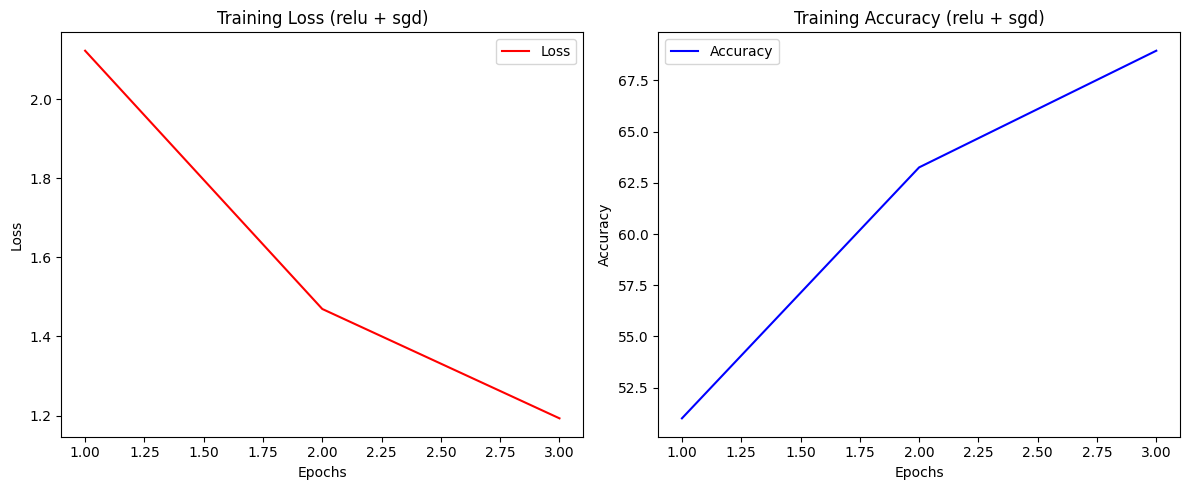

In [8]:
# Compute final averages and identify best combinations
best_accuracy = -1
best_accuracy_combo = None
best_error = float('inf')
best_error_combo = None

print("\nFinal Results Across All Folds:")
for (activation, optimizer), data in results.items():
    mean_error = np.mean(data['errors'])
    std_error = np.std(data['errors'])
    mean_accuracy = np.mean(data['accuracies'])
    std_accuracy = np.std(data['accuracies'])

    print(f"Activation: {activation}, Optimizer: {optimizer}, "
          f"Mean Error: {mean_error:.4f} ± {std_error:.4f}, "
          f"Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

    # Update best accuracy combination
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_accuracy_combo = (activation, optimizer)

    # Update best error combination
    if mean_error < best_error:
        best_error = mean_error
        best_error_combo = (activation, optimizer)

end_time = time.time()

print("\n=== Best Combinations ===")
print(f"🏆 Best Accuracy: {best_accuracy:.4f} using Activation: {best_accuracy_combo[0]}, Optimizer: {best_accuracy_combo[1]}")
print(f"🎯 Best (Lowest) Error: {best_error:.4f} using Activation: {best_error_combo[0]}, Optimizer: {best_error_combo[1]}")

print(f"\nTotal Execution Time: {(end_time - start_time):.2f} seconds")

# Plot for best accuracy combination
best_loss_history = np.mean(results[best_accuracy_combo]['loss_history'], axis=0)
best_acc_history = np.mean(results[best_accuracy_combo]['acc_history'], axis=0)

epochs = range(1, len(best_loss_history) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, best_loss_history, label='Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss ({best_accuracy_combo[0]} + {best_accuracy_combo[1]})')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, best_acc_history, label='Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Training Accuracy ({best_accuracy_combo[0]} + {best_accuracy_combo[1]})')
plt.legend()

plt.tight_layout()
plt.show()
